[1 - Prepare the data](#1---Prepare-the-data-)<br>
&ensp;&ensp;[1.1 - Generate annotation files](#1.1---Generate-annotation-files-(see-here))<br>
&ensp;&ensp;[1.2 - Create a subset for fast prototyping](#1.2---Create-a-subset-for-fast-prototyping)<br>
&ensp;&ensp;[1.3 - Compute features and write them to TFRecord](#1.3---Compute-features-and-write-them-to-TFRecord-files)<br>
&ensp;&ensp;[1.4 - Check some TFRecord](#1.4---Check-some-TFRecord)<br>
&ensp;&ensp;[1.5 - Check some other TFRecord](#1.5---Check-some-other-TFRecord)<br>
[2 - Training](#2---Training)<br>
&ensp;&ensp;[2.1 - Generate a train/valid split to monitor the performance on unseen data](#2.1---Generate-a-train/valid-split-to-monitor-the-performance-on-unseen-data)<br>
&ensp;&ensp;[2.2 - Count the number of batches in the train and valid sets](#2.2---Count-the-number-of-batches-in-the-train-and-valid-sets)<br>
&ensp;&ensp;[2.3 - Write feature extraction and training config files](#2.3---Write-feature-extraction-and-training-config-files)<br>
&ensp;&ensp;[2.4 - Train](#2.4---Train)


# 1 - Prepare the data

Original challenge data, as found at https://www.kaggle.com/c/freesound-audio-tagging-2019/data.
Audio data is resampled to 22050 Hz for faster prototyping.

In [1]:
! tree /home/jul/data/freesound-audio-tagging-2019/ -I 'subset*|annotations*|*wav|test'

/home/jul/data/freesound-audio-tagging-2019/
├── custom_subsets
├── sample_submission.csv
└── train
    ├── train_curated
    │   ├── audio
    │   ├── audio_22050hz
    │   └── train_curated.csv
    └── train_noisy
        ├── audio
        ├── audio_22050hz
        └── train_noisy.csv

8 directories, 3 files


## 1.1 - Generate annotation files (see [here](https://github.com/phaunos/phaunos_ml/blob/7fe9a4d07821a3ae0a5cdc353dc27fd332c5132c/phaunos_ml/utils/annotation_utils.py))

**Note**: Using annotation files here might be overkill because the annotations are "per file", but this is a generic way to handle any kind of annotations, including those applied to regions of a file (i.e. with start/end times).

In [2]:
from challenge_utils.dcase2019_task2_utils import get_class_list, generate_ann_files

In [3]:
class_list = get_class_list('/home/jul/data/freesound-audio-tagging-2019/sample_submission.csv')

In [4]:
print(class_list)

['Accelerating_and_revving_and_vroom', 'Accordion', 'Acoustic_guitar', 'Applause', 'Bark', 'Bass_drum', 'Bass_guitar', 'Bathtub_(filling_or_washing)', 'Bicycle_bell', 'Burping_and_eructation', 'Bus', 'Buzz', 'Car_passing_by', 'Cheering', 'Chewing_and_mastication', 'Child_speech_and_kid_speaking', 'Chink_and_clink', 'Chirp_and_tweet', 'Church_bell', 'Clapping', 'Computer_keyboard', 'Crackle', 'Cricket', 'Crowd', 'Cupboard_open_or_close', 'Cutlery_and_silverware', 'Dishes_and_pots_and_pans', 'Drawer_open_or_close', 'Drip', 'Electric_guitar', 'Fart', 'Female_singing', 'Female_speech_and_woman_speaking', 'Fill_(with_liquid)', 'Finger_snapping', 'Frying_(food)', 'Gasp', 'Glockenspiel', 'Gong', 'Gurgling', 'Harmonica', 'Hi-hat', 'Hiss', 'Keys_jangling', 'Knock', 'Male_singing', 'Male_speech_and_man_speaking', 'Marimba_and_xylophone', 'Mechanical_fan', 'Meow', 'Microwave_oven', 'Motorcycle', 'Printer', 'Purr', 'Race_car_and_auto_racing', 'Raindrop', 'Run', 'Scissors', 'Screaming', 'Shatter', 

In [5]:
generate_ann_files('/home/jul/data/freesound-audio-tagging-2019/train', class_list)

Annotation file contains all annotations of a given audio file. Each line represent a region and one or more label ids:
    start_time,end_time(-1 if the annotation is for the whole audio file, as in our case),label_ids (joined by '#'):

In [6]:
!head -5 /home/jul/data/freesound-audio-tagging-2019/train/train_noisy/annotations/* | head -8

==> /home/jul/data/freesound-audio-tagging-2019/train/train_noisy/annotations/00097e21.ann <==
0.000,-1.000,7

==> /home/jul/data/freesound-audio-tagging-2019/train/train_noisy/annotations/000b6cfb.ann <==
0.000,-1.000,51

==> /home/jul/data/freesound-audio-tagging-2019/train/train_noisy/annotations/00116cd2.ann <==
0.000,-1.000,37#47
head: error writing 'standard output': Broken pipe


## 1.2 - Create a subset for fast prototyping

In [7]:
import numpy as np
from phaunos_ml.utils.dataset_utils import create_subset, dataset_stat_per_file

ROOT_PATH = '/home/jul/data/freesound-audio-tagging-2019/train/'

In [8]:
# Pick 10 classes randomly
subset_label_set = set(np.random.choice(range(len(class_list)), 10, replace=False))
print(subset_label_set)

{34, 39, 41, 74, 45, 46, 48, 17, 22, 26}


In [9]:
# Create a data subset with all files annotated with at least one of these classes.
subset_filename = create_subset(
    ROOT_PATH,
    ['train_noisy', 'train_curated'],
    '/home/jul/data/freesound-audio-tagging-2019/custom_subsets',
    audio_dirname='audio_22050hz',
    label_set=subset_label_set)
print(subset_filename)

/home/jul/data/freesound-audio-tagging-2019/custom_subsets/subset_1571241326/subset_1571241326.csv


This basically create a file with a unique name (*subset_&lt;timestamp&gt;.csv*) containing a list of files with their annotations (intersecting with label_set):

In [10]:
!head -10 "$subset_filename"

#class subset: 17,22,26,34,39,41,45,46,48,74
train_noisy/audio_22050hz/02df08d2.wav
train_noisy/audio_22050hz/b65fb601.wav
train_noisy/audio_22050hz/364ac57b.wav
train_noisy/audio_22050hz/36eb7e34.wav
train_noisy/audio_22050hz/c5282d77.wav
train_noisy/audio_22050hz/68a1ab1c.wav
train_noisy/audio_22050hz/2a01e8c0.wav
train_noisy/audio_22050hz/9c6bc365.wav
train_noisy/audio_22050hz/79923e2a.wav


In [12]:
# Show dataset stats
# Note: The total number of instances might be higher than the number of audio files because a file might have multiple labels
d_num, d_dur = dataset_stat_per_file(
    ROOT_PATH,    
    subset_filename,
    audio_dirname='audio_22050hz')
print("Class index, number of files, total duration (in s)") 
for k, v in sorted(d_num.items()):
    if k in subset_label_set:
        print(f' {k:<10},{v:<10},{d_dur[k]:<10.3f}')

3693it [00:00, 14297.85it/s]

Class index, number of files, total duration (in s)
 17        ,375       ,5033.573  
 22        ,375       ,5439.672  
 26        ,375       ,4623.895  
 34        ,375       ,4565.928  
 39        ,375       ,4855.031  
 41        ,375       ,4621.564  
 45        ,375       ,4876.479  
 46        ,375       ,4678.907  
 48        ,349       ,5214.030  
 74        ,375       ,5453.991  


## 1.3 - Compute features and write them to [TFRecord](https://www.tensorflow.org/tutorials/load_data/tf_records) files

In [13]:
import os
from phaunos_ml.utils.feature_utils import MelSpecExtractor
from phaunos_ml.utils.dataset_utils import dataset2tfrecords
import tensorflow as tf

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.InteractiveSession(config=config)

In [14]:
# Log-mel spectrogram in 2s examples
feature_extractor = MelSpecExtractor(n_fft=512,
                                     hop_length=128,
                                     n_mels = 128,
                                     example_duration=2,
                                     example_hop_duration=1)

In [15]:
# Process our subset. TFRecords are written in 
tfrecord_path = os.path.join(os.path.dirname(subset_filename), 'features')
dataset2tfrecords(ROOT_PATH,
                 subset_filename,
                 tfrecord_path,
                 feature_extractor,
                 audio_dirname='audio_22050hz')

100%|██████████| 3694/3694 [07:07<00:00, 11.41it/s]


## 1.4 - Check some TFRecord

In [16]:
import random
import tensorflow as tf
from phaunos_ml.utils import tf_utils
import matplotlib.pyplot as plt
%matplotlib inline

In [20]:
subset_dir = os.path.dirname(subset_filename)
sometfrecord_path = os.path.join(subset_dir, 'features/positive/train_curated/audio_22050hz/')

In [21]:
sometfrecord = os.path.join(
    sometfrecord_path,
    random.sample(os.listdir(sometfrecord_path), 1)[0]
)

In [22]:
print(sometfrecord)

/home/jul/data/freesound-audio-tagging-2019/custom_subsets/subset_1571241326/features/positive/train_curated/audio_22050hz/1089aeec.tf


In [23]:
someexamples = tf_utils.tfrecord2example(sometfrecord, feature_extractor)
print(someexamples)

W1016 18:12:17.782863 139633882945344 deprecation.py:323] From /home/jul/dev/phaunos_ml/phaunos_ml/utils/tf_utils.py:44: DatasetV1.make_one_shot_iterator (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.
W1016 18:12:17.790887 139633882945344 deprecation_wrapper.py:119] From /home/jul/dev/phaunos_ml/phaunos_ml/utils/tf_utils.py:51: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



[{'data': array([[-18.420513, -18.415863, -18.38124 , ..., -10.849743, -11.563427,
        -10.942354],
       [-18.420559, -18.417158, -18.391706, ..., -11.163236, -11.876721,
        -11.255829],
       [-18.398579, -18.416859, -18.360722, ...,  -9.748999, -11.181066,
        -10.833606],
       ...,
       [-18.370537, -18.354282, -18.360264, ..., -13.423541, -13.832775,
        -14.486678],
       [-18.410028, -18.371195, -18.364223, ..., -14.899334, -15.363706,
        -16.039232],
       [-18.41251 , -18.407074, -18.399355, ..., -16.423122, -16.921602,
        -17.850458]], dtype=float32), 'filename': b'train_curated/audio_22050hz/1089aeec.tf', 'labels': b'17', 'times': array([0.       , 1.9911112], dtype=float32)}, {'data': array([[-18.420454, -18.3106  , -18.226353, ..., -18.34315 , -18.358091,
        -18.354628],
       [-18.420515, -18.339067, -18.275074, ..., -18.36344 , -18.374563,
        -18.371988],
       [-18.29477 , -18.25705 , -17.89514 , ..., -18.397604, -18.416666

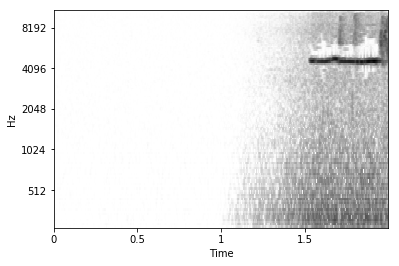

In [24]:
# First example in the TFRecord
feature_extractor.plot(someexamples[0]['data'])

## 1.5 - Check some other TFRecord

In [25]:
someothertfrecord = os.path.join(
    sometfrecord_path,
    random.sample(os.listdir(sometfrecord_path), 1)[0]
)
print(someothertfrecord)

/home/jul/data/freesound-audio-tagging-2019/custom_subsets/subset_1571241326/features/positive/train_curated/audio_22050hz/328626b4.tf


### As examples

In [26]:
otherexamples = tf_utils.tfrecord2example(someothertfrecord, feature_extractor)

In [27]:
print(otherexamples)

[{'data': array([[-18.420681, -18.420681, -18.420681, ..., -18.420681, -18.420681,
        -17.907999],
       [-18.420681, -18.420681, -18.420681, ..., -18.420681, -18.420681,
        -18.022287],
       [-18.420681, -18.420681, -18.420681, ..., -18.420681, -18.420681,
        -17.69262 ],
       ...,
       [-18.420681, -18.420681, -18.420681, ..., -18.420681, -18.420681,
        -18.379234],
       [-18.420681, -18.420681, -18.420681, ..., -18.420681, -18.420681,
        -18.410856],
       [-18.420681, -18.420681, -18.420681, ..., -18.420681, -18.420681,
        -18.418726]], dtype=float32), 'filename': b'train_curated/audio_22050hz/328626b4.tf', 'labels': b'22', 'times': array([0.       , 1.9911112], dtype=float32)}, {'data': array([[-18.420681 , -18.420681 , -18.420681 , ..., -18.38675  ,
        -18.418127 , -18.411533 ],
       [-18.420681 , -18.420681 , -18.420681 , ..., -18.395773 ,
        -18.418814 , -18.413988 ],
       [-18.420681 , -18.420681 , -18.420681 , ..., -18.368

### As input (features + one-hot encoded labels) to the model

In [28]:
subset_class_list = sorted(list(subset_label_set)) # labels are one-hot encoded according to this list

In [29]:
print(subset_class_list)

[17, 22, 26, 34, 39, 41, 45, 46, 48, 74]


In [30]:
example_as_input = tf_utils.tfrecord2data(someothertfrecord, feature_extractor, subset_class_list)

W1016 18:12:40.532290 139633882945344 deprecation.py:323] From /home/jul/dev/phaunos_ml/phaunos_ml/utils/tf_utils.py:143: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [31]:
# model_input is a list of tuple (<features>, <one-hot encoded labels>)
print(example_as_input)

[(array([[[-18.420681, -18.420681, -18.420681, ..., -18.420681,
         -18.420681, -17.907999],
        [-18.420681, -18.420681, -18.420681, ..., -18.420681,
         -18.420681, -18.022287],
        [-18.420681, -18.420681, -18.420681, ..., -18.420681,
         -18.420681, -17.69262 ],
        ...,
        [-18.420681, -18.420681, -18.420681, ..., -18.420681,
         -18.420681, -18.379234],
        [-18.420681, -18.420681, -18.420681, ..., -18.420681,
         -18.420681, -18.410856],
        [-18.420681, -18.420681, -18.420681, ..., -18.420681,
         -18.420681, -18.418726]]], dtype=float32), array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)), (array([[[-18.420681 , -18.420681 , -18.420681 , ..., -18.38675  ,
         -18.418127 , -18.411533 ],
        [-18.420681 , -18.420681 , -18.420681 , ..., -18.395773 ,
         -18.418814 , -18.413988 ],
        [-18.420681 , -18.420681 , -18.420681 , ..., -18.368956 ,
         -18.350111 , -18.355297 ],
        ...,
      

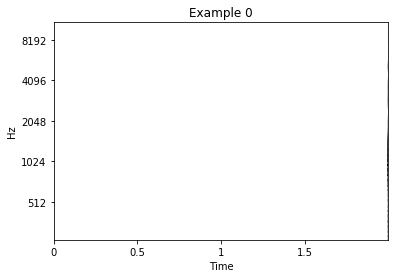

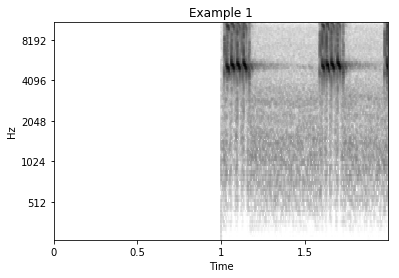

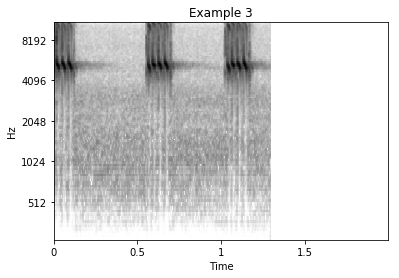

In [32]:
# Plot features for random examples from the selected file
ind = sorted(random.sample(range(len(example_as_input)),min(len(example_as_input), 3)))
for i in ind:    
    plt.figure()
    feature_extractor.plot(example_as_input[i][0][0])
    plt.title(f'Example {i}')

# 2 - Training

## 2.1 - Generate a train/valid split to monitor the performance on unseen data

In [33]:
from phaunos_ml.utils.dataset_utils import split_dataset

In [34]:
# This generates 2 files,
# /subset/path/subset_name.train.csv containing 80% of the data (training dataset)
# /subset/path/subset_name.test.csv containing 20% of the data (validation dataset, to select the model)
split_dataset(ROOT_PATH, subset_filename, audio_dirname='audio_22050hz', test_size=0.2)

/home/jul/data/freesound-audio-tagging-2019/custom_subsets/subset_1571241326/subset_1571241326.train.csv written
/home/jul/data/freesound-audio-tagging-2019/custom_subsets/subset_1571241326/subset_1571241326.test.csv written


## 2.2 - Count the number of batches in the train and valid sets

In [35]:
from phaunos_ml.utils.dataset_utils import dataset_stat_per_example
BATCH_SIZE = 32

In [37]:
# training set
n_train_batches, n_train_examples_per_class = dataset_stat_per_example(
    ROOT_PATH,
    subset_filename.replace('.csv', '.train.csv'),
    os.path.join(os.path.dirname(subset_filename), 'features/positive'),
    feature_extractor.feature_shape,
    subset_class_list,
    audio_dirname='audio_22050hz',
    batch_size=BATCH_SIZE)
print(f'Num training batches: {n_train_batches} (i.e. {n_train_batches * BATCH_SIZE} examples)')
for c, n in zip(subset_class_list, n_train_examples_per_class):
    print(f'Class {c:2}: {n} examples')
# Note: the number of examples n_train_batches * BATCH_SIZE is <= to sum(n_train_examples_per_class)
# because data is multilabel
print(f'{n_train_batches * BATCH_SIZE} <= {np.sum(n_train_examples_per_class)}')

Num training batches: 1184 (i.e. 37888 examples)
Class 17: 3915 examples
Class 22: 4306 examples
Class 26: 3621 examples
Class 34: 3439 examples
Class 39: 3738 examples
Class 41: 3508 examples
Class 45: 3713 examples
Class 46: 3547 examples
Class 48: 4169 examples
Class 74: 4297 examples
37888 <= 38253


In [38]:
# valid set
n_valid_batches, n_valid_examples_per_class = dataset_stat_per_example(
    ROOT_PATH,
    subset_filename.replace('.csv', '.test.csv'),
    os.path.join(os.path.dirname(subset_filename), 'features/positive'),
    feature_extractor.feature_shape,
    subset_class_list,
    audio_dirname='audio_22050hz',
    batch_size=BATCH_SIZE)
print(f'Num valid batches: {n_valid_batches} (i.e. {n_valid_batches * BATCH_SIZE} examples)')
for c, n in zip(subset_class_list, n_valid_examples_per_class):
    print(f'Class {c:2}: {n} examples')
# Note: the number of examples n_valid_batches * BATCH_SIZE is <= to sum(n_valid_examples_per_class)
# because data is multilabel
print(f'{n_valid_batches * BATCH_SIZE} <= {np.sum(n_valid_examples_per_class)}')

Num valid batches: 334 (i.e. 10688 examples)
Class 17: 1081 examples
Class 22: 1052 examples
Class 26: 986 examples
Class 34: 1122 examples
Class 39: 1072 examples
Class 41: 1108 examples
Class 45: 1123 examples
Class 46: 1111 examples
Class 48: 1011 examples
Class 74: 1102 examples
10688 <= 10768


## 2.3 - Write feature extraction and training config files

In [40]:
import json

EPOCHS = 10

In [41]:
# Write feature extractor's config file
feature_extractor.config2file(os.path.join(subset_dir, 'features/positive', 'featex_config.json'))

In [42]:
# Write training config file

training_dir = os.path.join(subset_dir, 'training')

training_config = {}
training_config['root_path'] = ROOT_PATH
training_config['feature_path'] = os.path.join(subset_dir, 'features/positive')
training_config['train_set_file'] = subset_filename.replace('.csv', '.train.csv')
training_config['audio_dirname'] = 'audio_22050hz'
training_config['annotation_dirname'] = 'annotations'
training_config['n_train_batches'] = n_train_batches
training_config['batch_size'] = BATCH_SIZE
training_config['multilabel'] = True
training_config['epochs'] = EPOCHS
training_config['out_dir'] = training_dir
training_config['valid_set_file'] = subset_filename.replace('.csv', '.test.csv')
training_config['n_valid_batches'] = n_valid_batches

training_config_path = os.path.join(training_dir, 'training_config.json')
os.makedirs(training_dir)

with open(training_config_path, 'w') as training_config_file:
    json.dump(training_config, training_config_file)

## 2.4 - Train

In [43]:
from phaunos_ml import train

In [ ]:
train.process(training_config_path)

W1016 18:19:00.724389 139633882945344 deprecation.py:506] From /home/jul/.miniconda3/envs/phaunos_ml/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mels (InputLayer)            [(32, 1, 128, 344)]       0         
_________________________________________________________________
l1_conv (Conv2D)             (32, 32, 126, 342)        288       
_________________________________________________________________
l1_bn (BatchNormalization)   (32, 32, 126, 342)        96        
_________________________________________________________________
l1 (Activation)              (32, 32, 126, 342)        0         
_________________________________________________________________
l1_mp (MaxPooling2D)         (32, 32, 62, 170)         0         
_________________________________________________________________
l2_conv (Conv2D)             (32, 32, 58, 166)         25600     
_________________________________________________________________
l2_bn (BatchNormalization)   (32, 32, 58, 166)         96    